<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw15/Homework15_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install denoising_diffusion_pytorch

# Imports

In [33]:
import copy

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as D
from torch import autograd

from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from denoising_diffusion_pytorch import Unet

import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

In [34]:
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Data

In [45]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((16, 16)),
    transforms.Normalize((0.5), (0.5)),
])

In [46]:
train_data = MNIST(root='./data/', train=True, download=True, transform=transform)
val_data = MNIST(root='./data/', train=False, download=True, transform=transform)

In [47]:
BATCH_SIZE = 128

In [59]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True
)
val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    drop_last=True
)

# Utils

In [60]:
def f_(f, x):
    x = x.clone()
    
    with torch.enable_grad():
        if not x.requires_grad:
            x.requires_grad = True

        y = f(x)
        
        (grad, ) = autograd.grad(y.sum(), x, create_graph=False)
        
    return grad

In [61]:
@torch.no_grad()
def solve_sde(x, f, g, ts=0, tf=1, dt=1e-3):
    for t in tqdm(np.arange(ts, tf, dt)):
        tt = torch.FloatTensor([t]).to(device)
        z = torch.randn_like(x).to(device)
        x = x + f(x, tt) * dt + g(tt) * z * abs(dt) ** 0.5
        
    return x

In [81]:
@torch.no_grad()
def show_imgs(x):
    x = x.detach().cpu()
    
    img = make_grid(x, nrow=5)
    img = img.permute(1, 2, 0)
    img = img * 0.5 + 0.5

    plt.imshow(img.numpy())
    plt.axis('off')
    plt.show()

# Question 1. DDPM

В этом задание вам предлагается реализовать диффузную модель с непрерывным временем на основе DDPM. Технический код уже написан, нужно лишь восстановить содержательные функции.

In [70]:
class ContDDPM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.eps_th = Unet(
            dim=16,
            dim_mults=(1, 2, 3),
            channels=1
        )
        
    def device(self):
        return next(self.parameters()).device
        
    def gamma(self, t):
        return torch.log(torch.expm1(1e-4 + 10 * t ** 2))
    
    # Coefficient \bar{a}_t
    # see presentation, slide 19
    def a_bar(self, t):
        g = self.gamma(t)
        return torch.sigmoid(-g)
    
    def sigma_2(self, t):
        return 1 - self.a_bar(t)
    
    def log_a_bar_sqrt_(self, t):
        return 0.5 * f_(lambda s: torch.log(self.a_bar(s)), t)
    
    # Coefficient f(x, t)
    # see presentation, slide 31
    def f(self, x_t, t):
        return self.log_a_bar_sqrt_(t) * x_t
    
    # Coefficient g^2(t)
    # see presentation, slide 31
    def g_2(self, t):
        return f_(self.sigma_2, t) - 2 * self.log_a_bar_sqrt_(t) * self.sigma_2(t)
    
    # Learned score function
    # see presentation, slide 28
    def score(self, x_t, t):
        """
        x_t: tensort [bs, 1, 16, 16]
        t: tensort [bs]

        Returns
        - score: tensor  [bs, 1, 16, 16]
        """
        std = torch.sqrt(self.sigma_2(t))
        return - self.eps_th(x_t, t).squeeze(-1) / std
    
    def sample_t(self, bs):
        device = self.device()
        t = torch.rand(bs).to(device)
        return t
        
    # Transition sampling q(x_t|x_0)
    # see presentation, slide 19 and 25
    def sample_x_t(self, x_0, t):
        """
        x_0: tensort [bs, 1, 16, 16]
        t: tensort [bs]

        Returns
        - x_t: tensor  [bs, 1, 16, 16]
        - eps: accumulated noise tensor [bs, 1, 16, 16]
        """
        noise = torch.randn_like(x_0).permute((1, 2, 3, 0))
        std = torch.sqrt(self.sigma_2(t))
        eps = (noise * std).permute((3, 0, 1, 2))
        x_t = x_0 + eps

        return x_t, eps

    # Loss function
    # see presentation, slide 26
    def get_loss(self, x_0):
        device = self.device()
        bs = x_0.shape[0]
        data_dims = tuple(np.arange(1, len(x_0.shape)))
        
        t = self.sample_t(bs)
        x_t, eps = self.sample_x_t(x_0, t)

        eps = torch.flatten(eps, 1)
        pred = torch.flatten(self.eps_th(x_t, t), 1)

        loss = F.mse_loss(eps, pred) * x_0.shape[-1] * x_0.shape[-2]
        
        return loss
        
    # Sampling according to reverse SDE
    # see presentation, slide 32
    # Hint: use solve_sde function
    def sample_sde(self, bs):
        """
        bs: int

        Returns
        - x_0: tensor  [bs, 1, 16, 16] generated data
        """
        x_T = torch.randn((bs, 1, 16, 16), device=device)
        
        def f(x, t):
          g2 = self.g_2(t)
          grad = self.score(x, t).permute((1, 2, 3, 0))
          return self.f(x, t) - (g2 * grad).permute((3, 0, 1, 2))
        
        def g(t):
          return torch.sqrt(self.g_2(t))

        return solve_sde(x_T, f, g, 1, 0, -1e-3)

## Training

In [71]:
def calc_loss(ddpm, x):
    loss = ddpm.get_loss(x)

    return loss

In [72]:
def train_step(ddpm, x, optim):
    loss_total = calc_loss(ddpm, x)
    
    optim.zero_grad()
    loss_total.backward()
    optim.step()
    
    return loss_total.item()

In [73]:
def train_epoch(ddpm, data_loader, optim):
    ddpm.train()

    losses = []
    for x, _ in data_loader:
        x = x.to(device)

        loss_total = train_step(ddpm, x, optim)
        
        losses.append(loss_total)
        
    loss_mean = np.mean(losses)
    return loss_mean

In [74]:
def val_epoch(ddpm, data_loader):
    ddpm.eval()

    losses = []
    for x, _ in data_loader:
        x = x.to(device)

        total_loss = calc_loss(ddpm, x).item()
        
        losses.append(total_loss)
        
    loss_mean = np.mean(losses)

    return loss_mean

In [77]:
def train(ddpm, train_loader, val_loader, optim, epochs):
    for epoch in trange(epochs):
        train_loss = train_epoch(ddpm, train_loader, optim)
        with torch.no_grad():
          val_loss = val_epoch(ddpm, val_loader)
        print(f"train: {train_loss}    val: {val_loss}")

## Experiment

In [78]:
ddpm = ContDDPM()
ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr=2e-4)

train(ddpm, train_loader, val_loader, optim, epochs=25)

  0%|          | 0/25 [00:00<?, ?it/s]

train: 42.13660701115926    val: 20.321595045236442
train: 18.72349939794622    val: 17.457541710291153
train: 16.79225647347605    val: 16.144061773251263
train: 15.811577195795174    val: 15.268526456294916
train: 15.063646664986244    val: 14.68504376289172
train: 14.541013640216272    val: 14.256099480849047
train: 14.135204787947174    val: 13.943764662131285
train: 13.81676239029974    val: 13.576945133698292
train: 13.579207793260233    val: 13.26739431038881
train: 13.258773879108267    val: 13.066076633257744
train: 13.084889576985287    val: 12.964672528780424
train: 12.900375838972565    val: 12.724901040395102
train: 12.726053602675087    val: 12.70668282875648
train: 12.637306938823471    val: 12.472830136617025
train: 12.475125502317379    val: 12.488781122060923
train: 12.414982410577627    val: 12.388211788275303
train: 12.25527345828521    val: 12.38425961518899
train: 12.189229999851976    val: 12.01816116235195
train: 12.094042348046589    val: 11.969666481018066
tra

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


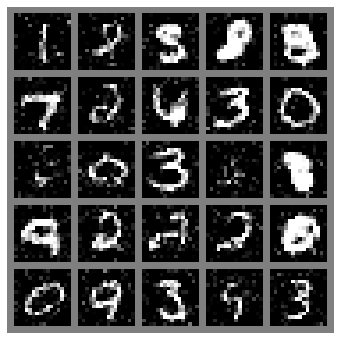

In [83]:
x = ddpm.sample_sde(bs=25)

plt.rcParams["figure.figsize"] = [6., 6.]

show_imgs(x)

# Bonus. Conditional generation

На паре мы обсуждали возможность делать условную генерацию с помощью диффузных моделей (см. презентацию, слайд 35). Бонусное задание - реализовать генерацию с условием на класс. Для этого нужно:

*   Обучить безусловную генерацию из первого задания
*   Обучить классификатор обусловленный на время
*   Собрать все вместе

